In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import cv2

In [10]:
device = torch.device('cpu')

In [11]:
VGG_11 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11_bn', pretrained=True)
class VGG_CAM(nn.Module):
    def __init__(self, features = VGG_11.features, n_classes = 3):
        super(VGG_CAM, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, n_classes,bias=False)
            
    def forward(self, x):
        x = self.features(x)
        self.featuremap1 = x.detach()
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
preprocess = transforms.Compose([
    transforms.CenterCrop(1024),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

Using cache found in /home/cz2064/.cache/torch/hub/pytorch_vision_v0.6.0


In [12]:
model = VGG_CAM().to(device)
files = torch.load('../Python File/checkpoint_Model.pt', map_location='cpu')
model.load_state_dict(files['best_model_wts'])

/scratch/cz2064/envs/dl4med/lib/python3.6/site-packages/torch/serialization.py:559: UserWarning: Couldn't retrieve source code for container of type VGG_CAM. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/scratch/cz2064/envs/dl4med/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/scratch/cz2064/envs/dl4med/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the 

<All keys matched successfully>

In [32]:
test_df_path = '/scratch/cz2064/myjupyter/BDML/Project/Phase5/Train_Test_Split/test.csv'
test_df = pd.read_csv(test_df_path)
test_df[200:]

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,type,label
200,64f86129-fe6b-4d8d-86fe-ed479b1ae97c,TCGA-77-A5GH-01A-01-TS1.E13EBA23-B0C4-497C-A93...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-77-A5GH,TCGA-77-A5GH-01A,Primary Tumor,Tumor-LUSC,1
201,2ea1f949-8064-40b0-9928-9985b7d18e8e,TCGA-62-A46P-01A-01-TS1.B5E86BA2-E157-44FA-B06...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-62-A46P,TCGA-62-A46P-01A,Primary Tumor,Tumor-LUAD,2
202,57bb8b7b-92c4-43c5-9c5b-d8c4ff6c9db0,TCGA-66-2770-01A-01-BS1.a10196d2-7a81-4e1e-a9a...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-66-2770,TCGA-66-2770-01A,Primary Tumor,Tumor-LUSC,1
203,15b674eb-5097-4b1d-9fea-e17f1b605d8e,TCGA-22-4604-11A-01-TS1.c9586bad-95e3-4d8d-983...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-22-4604,TCGA-22-4604-11A,Solid Tissue Normal,Normal,0
204,826d4e3f-113e-439b-a3ae-f700e1bccc62,TCGA-66-2783-01A-01-BS1.eaa9d7a3-34c1-4850-997...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-66-2783,TCGA-66-2783-01A,Primary Tumor,Tumor-LUSC,1
...,...,...,...,...,...,...,...,...,...,...
411,dd76a429-9fc2-47db-8ebc-8d6dda0bc99d,TCGA-50-6590-11A-01-TS1.fefe9444-70ce-4911-a03...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-50-6590,TCGA-50-6590-11A,Solid Tissue Normal,Normal,0
412,18f7943d-6a38-4ebc-ab56-354b4980c96a,TCGA-37-4135-01A-01-TS1.fd901f17-fe66-4709-b28...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-37-4135,TCGA-37-4135-01A,Primary Tumor,Tumor-LUSC,1
413,05919b71-18da-47b5-b5fb-af3ff07a871a,TCGA-78-7163-11A-01-TS1.1ce6c71a-1466-48d2-89d...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-78-7163,TCGA-78-7163-11A,Solid Tissue Normal,Normal,0
414,08172153-d520-4d0d-9291-faebfbd4d92d,TCGA-56-8307-01A-01-TS1.7537de75-53be-4ace-aec...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-56-8307,TCGA-56-8307-01A,Primary Tumor,Tumor-LUSC,1


In [14]:
test_layer2_path = '/scratch/cz2064/myjupyter/BDML/Project/Phase5/Train_Test_Split/test_layer2_subimages.csv'
test_layer2 = pd.read_csv(test_layer2_path)
test_layer2.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,type,label,Subimage File
0,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,Tumor-LUSC,1,subsample_0_0.jpg
1,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,Tumor-LUSC,1,subsample_0_1.jpg
2,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,Tumor-LUSC,1,subsample_0_2.jpg
3,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,Tumor-LUSC,1,subsample_1_0.jpg
4,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,Tumor-LUSC,1,subsample_1_1.jpg


In [15]:
imgage_folder = '/scratch/cz2064/myjupyter/BDML/Project/Data/data_layer2_subimages/'

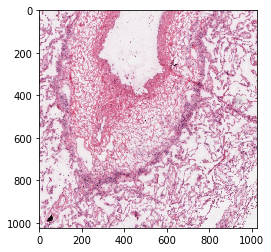

In [34]:
# Normal sample
sample = test_df.loc[[203]]
file_id = sample['File ID'].values[0]
file_name = sample['File Name'].values[0]

subsamples = test_layer2.loc[test_layer2['File ID']==file_id]
subsamples = subsamples.iloc[[10]]
subsamples_name = subsamples['Subimage File'].values[0]

image_path = imgage_folder + file_id + '/' + subsamples_name
normal_sample = Image.open(image_path)
plt.imshow(normal_sample)

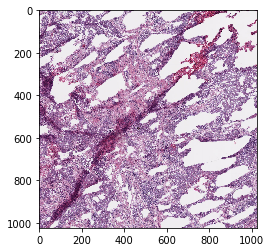

In [41]:
# LUSC sample
sample = test_df.loc[[202]]
file_id = sample['File ID'].values[0]
file_name = sample['File Name'].values[0]

subsamples = test_layer2.loc[test_layer2['File ID']==file_id]
subsamples = subsamples.iloc[[45]]
subsamples_name = subsamples['Subimage File'].values[0]

image_path = imgage_folder + file_id + '/' + subsamples_name
LUSC_sample = Image.open(image_path)
plt.imshow(LUSC_sample)

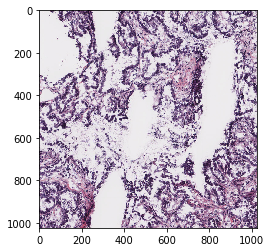

In [48]:
# LUAD sample
sample = test_df.loc[[201]]
file_id = sample['File ID'].values[0]
file_name = sample['File Name'].values[0]

subsamples = test_layer2.loc[test_layer2['File ID']==file_id]
subsamples = subsamples.iloc[[35]]
subsamples_name = subsamples['Subimage File'].values[0]

image_path = imgage_folder + file_id + '/' + subsamples_name
LUAD_sample = Image.open(image_path)
plt.imshow(LUAD_sample)

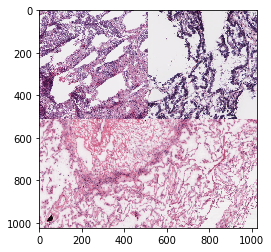

In [49]:
new_sample = Image.new('RGB', (1024, 1024))
new_sample.paste(normal_sample.crop((0, 512, 1024, 1024)), (0, 512, 1024, 1024))
new_sample.paste(LUSC_sample.crop((0, 0, 512, 512)), (0, 0, 512, 512))
new_sample.paste(LUAD_sample.crop((0, 0, 512, 512)), (512, 0, 1024, 512))
plt.imshow(new_sample)

In [50]:
new_sample.save("new_sample.jpg") 

In [51]:
model.eval()
original_image = cv2.imread("new_sample.jpg")
image_tensor = preprocess(new_sample).unsqueeze(0)
sample_input = image_tensor.to(device,dtype=torch.float)
output = model(sample_input)
pre_class = output.data.max(-1)[1].cpu().numpy()

In [52]:
Feature_map = model.featuremap1.cpu().numpy()
print('Feature map:',Feature_map.shape)

Feature map: (1, 512, 32, 32)


In [53]:
params = list(model.parameters())
weight_softmax = np.squeeze(params[-1].data.cpu().numpy())
print('Weights:',weight_softmax.shape)

Weights: (3, 512)


In [54]:
# Feature map 1
weights_map1 = weight_softmax[0]
cam_1 = weights_map1.dot(Feature_map.reshape((512,32*32)))
cam_1 = cam_1.reshape(32,32)
# Feature map 2
weights_map2 = weight_softmax[1]
cam_2 = weights_map2.dot(Feature_map.reshape((512,32*32)))
cam_2 = cam_2.reshape(32,32)
# Feature map 3
weights_map3 = weight_softmax[2]
cam_3 = weights_map3.dot(Feature_map.reshape((512,32*32)))
cam_3 = cam_3.reshape(32,32)

In [55]:
cam = cam_1
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
CAM = cv2.resize(cam_img, (1024,1024))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
cv2.imwrite('cam_1.jpg', heatmap*0.3+0.7*original_image)

True

In [56]:
cam = cam_2
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
CAM = cv2.resize(cam_img, (1024,1024))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
cv2.imwrite('cam_2.jpg', heatmap*0.3+0.7*original_image)

True

In [57]:
cam = cam_3
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
CAM = cv2.resize(cam_img, (1024,1024))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
cv2.imwrite('cam_3.jpg', heatmap*0.3+0.7*original_image)

True

In [58]:
pre_class

array([1])